In [1]:
!pip install ipywidgets --quiet
!pip install pytorch_lightning --quiet
!pip install wandb --quiet
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.1/977.1 kB 15.5 MB/s eta 0:00:00a 0:00:01


In [2]:
# Утилиты стандартной библиотеки
from functools import lru_cache
import os
import copy
import re
import random
import shutil
import pandas as pd
from tqdm import tqdm
from urllib.request import urlretrieve
from pathlib import Path

# Библиотеки для анализа данных
import numpy as np
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

# Библиотеки для обработки изображений
import cv2
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
from torchvision.transforms import ToPILImage
import torchvision.transforms as T
import torch.optim as optim

import tensorflow as tf

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
sns.set()

# Библиотеки для обучения
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from skimage.morphology import dilation, footprint_rectangle

from ultralytics import YOLO
from torchvision.models.detection.ssd import ssd300_vgg16
from torchvision.models import VGG16_Weights
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights


from glob import glob
from skimage.morphology import skeletonize
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import matplotlib
from skimage.measure import label, regionprops
from shapely.geometry import LineString 
from shapely import simplify
from scipy.spatial.distance import cdist  # Исправленный импорт
from torch.utils.data import Dataset, DataLoader
from collections import Counter

# Утилита для tqdm в Jupyter Notebook
from tqdm.auto import tqdm

# Определение устройства
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using device: {device}")

import wandb

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda


In [3]:
wandb.login(key="ca0f522a70ce0bd6b4a0aeb32424470b576c24d3")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: demoren (demoren_mipt). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Часть 3. Детекция объектов на дороге 🚗👫🚲

Современные системы помощи водителю и автономного вождения должны надежно распознавать различные объекты на дороге: от других участников движения до элементов дорожной инфраструктуры. В этой части вы создадите систему детекции пяти ключевых типов объектов: автомобилей, пешеходов, велосипедистов/мотоциклистов, дорожных знаков и светофоров.

#### Этапы работы

1. **Сбор данных.** Как и в первой части предлагается использовать несколько датасетов, например:
    - [Traffic Road Object Detection Polish 12k](https://www.kaggle.com/datasets/mikoajkoek/traffic-road-object-detection-polish-12k),
    - [Mapillary Vistas Image Data Collection](https://www.kaggle.com/datasets/kaggleprollc/mapillary-vistas-image-data-collection),
    - [N_O_1 Computer Vision Project](https://universe.roboflow.com/dice-6h29i/n_o_1),
    - [N_O_2 Computer Vision Project](https://universe.roboflow.com/nada-majd-e4uhb/n_o_2),
    - Любые другие подходящие датасеты по вашему выбору.

2. **Подготовка данных**
    - Проанализируйте классы в каждом датасете.
    - Скорее всего наборы классов в разных датасетах будут отличаться. Сделайте маппинг в необходмые нам 5 классов:
        * Объедините классы одинаковых объектов (например, `Green-Traffic-Light` и `Red-Traffic-Light`);
        * Отфильтруйте ненужные классы.

3. **Эксперименты с моделями.** Проведите различные эксперименты по обучению моделей, попробуйте разные архитектуры, например:
    - YOLO,
    - RetinaNet,
    - SSD,
    - Любые другие архитектуры по вашему выбору.

    Как и в части 1 рекомендуется логировать процесс обучения, примеры предсказаний и результаты в wandb/etc.


#### Бонус (альтернативный путь)
После прочтения условия 4 части, возможно у вас появится желание обучить специальную модель детекции для работы с видео, чтобы движение боксов было наиболее плавным и точным. Вы можете пойти по этому пути, но тогда вам потребуется самостоятельно:
- Найти подходящие видео-датасеты, содержащие разметку на хотя бы 4 класса: автомобили, пешеходы, дорожные знаки и светофоры;
- Изучить принципы работы и обучения моделей детекции и трекинга объектов на видео.

Если получится добиться хорошего качества модели трекинга объектов на видео, вы получите +20 бонусных баллов.

In [4]:
data = pd.read_csv("/kaggle/input/traffic-road-object-detection-polish-12k/data.csv")

data

,Set,Photos,Car,Different-Traffic-Sign,Red-Traffic-Light,Pedestrian,Warning-Sign,Pedestrian-Crossing,Green-Traffic-Light,Prohibition-Sign,Truck,Speed-Limit-Sign,Motorcycle
0,Test Set,166,687,547,163,137,79,82,52,48,66,22,4
1,Train Set,1178,4766,3370,805,812,544,476,402,396,409,230,38
2,Validation Set,327,1343,945,232,228,163,112,87,112,137,59,10
3,Test Set (Augmented),996,4122,3282,978,822,474,492,312,288,396,132,24
4,Train Set (Augmented),7068,28596,20220,4830,4872,3264,2856,2412,2376,2454,1380,228
5,Validation Set (Augmented),1962,8058,5670,1392,1368,978,672,522,672,822,354,60


In [5]:
elements = [
    "Car", "Different-Traffic-Sign", "Red-Traffic-Light",
    "Pedestrian", "Warning-Sign", "Pedestrian-Crossing", "Green-Traffic-Light",
    "Prohibition-Sign", "Truck", "Speed-Limit-Sign", "Motorcycle"
]

for i in range(0, len(elements), 1):
    print(f"Элемент '{elements[i]}' имеет индекс {i}")

Элемент 'Car' имеет индекс 0
Элемент 'Different-Traffic-Sign' имеет индекс 1
Элемент 'Red-Traffic-Light' имеет индекс 2
Элемент 'Pedestrian' имеет индекс 3
Элемент 'Warning-Sign' имеет индекс 4
Элемент 'Pedestrian-Crossing' имеет индекс 5
Элемент 'Green-Traffic-Light' имеет индекс 6
Элемент 'Prohibition-Sign' имеет индекс 7
Элемент 'Truck' имеет индекс 8
Элемент 'Speed-Limit-Sign' имеет индекс 9
Элемент 'Motorcycle' имеет индекс 10


Загрузим данные в генераторы, классы будем переопределять уже на инференсе.

In [109]:
def redefine_class(class_ids):
    class_ids = np.array(class_ids)
    new_classes = -1  # Изначально не присваиваем класс

    # Автомобили (0, 8 → 0)
    if np.any(np.isin(class_ids, [0, 8])):
        new_classes = 0
    
    # Пешеходы (4 → 3)
    elif np.any(class_ids == 4):
        new_classes = 3
        
    # Дорожные знаки (1, 3, 5, 7, 9 → 1)
    elif np.any(np.isin(class_ids, [1, 3, 5, 7, 9])):
        new_classes = 1
    
    # Светофоры (2, 6 → 2)
    elif np.any(np.isin(class_ids, [2, 6])):
        new_classes = 2
    
    
    # Мотоциклисты (10 → 4)
    elif np.any(class_ids == 10):
        new_classes = 4

    return new_classes
    
# Кастомный датасет
class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, target_size=640, shuffle=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.target_size = target_size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        self.shuffle = shuffle
        if self.shuffle:
            random.shuffle(self.image_files)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        img_file = self.image_files[index]
        img_path = os.path.join(self.image_dir, img_file)
        label_path = os.path.join(self.label_dir, img_file.rsplit('.', 1)[0] + ".txt")
        
        # Загружаем изображение
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (self.target_size, self.target_size), interpolation=cv2.INTER_LINEAR)
        
        # Загружаем аннотации и переопределяем классы
        labels = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    if len(parts) == 5:  # Формат: [class, x, y, w, h]
                        original_class = int(parts[0])
                        new_class = redefine_class(original_class)
                        if new_class != -1:
                            labels.append([new_class] + parts[1:])
        
        return np.array(img_resized), np.array(labels)

# Пользовательская функция collate_fn
def custom_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.from_numpy(np.stack(images, axis=0)).permute(0, 3, 1, 2).float()
    return images, list(labels)

# Задаем базовый путь и размер изображений
base_dir = "/kaggle/input/traffic-road-object-detection-polish-12k/road_detection/road_detection"
TARGET_SIZE = 640  # Размер изображений для YOLO

# Создаем датасеты для train, valid и test
train_dataset = CustomDataset(
    image_dir=os.path.join(base_dir, "train", "images"),
    label_dir=os.path.join(base_dir, "train", "labels"),
    target_size=TARGET_SIZE
)
valid_dataset = CustomDataset(
    image_dir=os.path.join(base_dir, "valid", "images"),
    label_dir=os.path.join(base_dir, "valid", "labels"),
    target_size=TARGET_SIZE
)
test_dataset = CustomDataset(
    image_dir=os.path.join(base_dir, "test", "images"),
    label_dir=os.path.join(base_dir, "test", "labels"),
    target_size=TARGET_SIZE
)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

# Пример использования: загрузим один batch из тренировочного датасета
images, labels = next(iter(valid_loader))
print(f"Batch shape: {images.shape}, Number of label entries: {len(labels)}")

Batch shape: torch.Size([16, 3, 640, 640]), Number of label entries: 16


Посмотрим, что лежит в наших генераторах

In [112]:
def show_image_with_labels(image, labels, target_size=TARGET_SIZE):
    img_draw = image.detach().cpu().numpy().transpose(1, 2, 0)  # Преобразуем из (C, H, W) в (H, W, C)
    img_draw = img_draw.astype(np.uint8)
    
    for ann in labels:
        # Предполагается, что формат метки: [class, x_center, y_center, width, height]
        cls, x_center, y_center, w_box, h_box = ann
        
        # Переводим координаты в пиксели
        x_center_pixel = x_center * target_size
        y_center_pixel = y_center * target_size
        w_pixel = w_box * target_size
        h_pixel = h_box * target_size
        
        # Вычисляем координаты верхнего левого и нижнего правого углов
        x_min = int(x_center_pixel - w_pixel / 2)
        y_min = int(y_center_pixel - h_pixel / 2)
        x_max = int(x_center_pixel + w_pixel / 2)
        y_max = int(y_center_pixel + h_pixel / 2)
        
        # Рисуем прямоугольник (цвет и толщина можно настроить)
        cv2.rectangle(img_draw, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
        # Пишем класс над прямоугольником
        cv2.putText(img_draw, str(int(cls)), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.9, (0, 255, 0), 2)
    
    # Отображаем изображение с аннотациями
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Изображение с аннотациями")
    plt.show()

# Получаем одну партию данных
images_batch, labels_batch = next(iter(valid_loader))

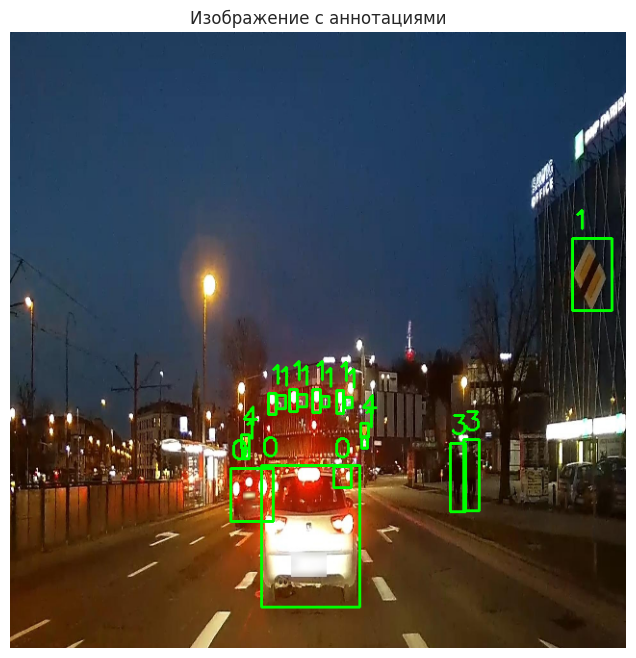

In [116]:
index = 3
sample_img = images_batch[index]
sample_labels = labels_batch[index]

# Отображаем изображение с аннотациями
show_image_with_labels(sample_img, sample_labels, target_size=TARGET_SIZE)

Создадим конфиг для модели

In [8]:
data_config = """
path: /kaggle/input/traffic-road-object-detection-polish-12k/road_detection/road_detection
train: train
val: valid

nc: 11
names: ['Car', 'Different-Traffic-Sign', 'Red-Traffic-Light', 'Pedestrian', 'Warning-Sign', 'Pedestrian-Crossing', 'Green-Traffic-Light', 'Prohibition-Sign', 'Truck', 'Speed-Limit-Sign', 'Motorcycle']
"""

data_config_path = 'data_config.yaml'
with open(data_config_path, 'w') as file:
    file.write(data_config)

Загрузим модель

In [9]:
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 182MB/s]


Обучим модель

In [10]:
wandb.init(project='cv_task_part3', name='YOLOv8')

model.train(data=data_config_path, epochs=10, imgsz=640, batch=48, save=True, project='cv_task_part3', name='YOLOv8', exist_ok=True)

wandb.finish()

Ultralytics 8.3.100 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data_config.yaml, epochs=10, time=None, patience=100, batch=48, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=cv_task_part3, name=YOLOv8, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/traffic-road-object-detection-polish-12k/road_detection/road_detection/train/labels... 10474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10474/10474 [02:06<00:00, 82.55it/s] 


train: WARNING ⚠️ Cache directory /kaggle/input/traffic-road-object-detection-polish-12k/road_detection/road_detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/traffic-road-object-detection-polish-12k/road_detection/road_detection/valid/labels... 935 images, 0 backgrounds, 0 corrupt: 100%|██████████| 935/935 [00:13<00:00, 67.85it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/traffic-road-object-detection-polish-12k/road_detection/road_detection/valid is not writeable, cache not saved.
Plotting labels to cv_task_part3/YOLOv8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to cv_task_part3/YOLOv8
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      11.4G      1.439      1.897      1.081         91        640: 100%|██████████| 219/219 [04:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


                   all        935       8981       0.66      0.447      0.518      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      11.5G      1.292     0.8385      1.016         88        640: 100%|██████████| 219/219 [04:00<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


                   all        935       8981      0.689       0.53      0.572      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      11.5G      1.274     0.7913      1.012         84        640: 100%|██████████| 219/219 [04:00<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


                   all        935       8981      0.682       0.53      0.576      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      11.5G      1.232     0.7367     0.9949         64        640: 100%|██████████| 219/219 [04:06<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


                   all        935       8981       0.76       0.56      0.626      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      11.5G      1.176     0.6734      0.974        122        640: 100%|██████████| 219/219 [04:21<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


                   all        935       8981      0.765      0.594      0.659      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      11.5G      1.128     0.6268     0.9551        115        640: 100%|██████████| 219/219 [04:14<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]

                   all        935       8981      0.816      0.605      0.679      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      11.5G      1.079     0.5836     0.9375        123        640: 100%|██████████| 219/219 [04:14<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]

                   all        935       8981      0.791      0.637      0.694      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      11.5G      1.033     0.5451      0.922         93        640: 100%|██████████| 219/219 [04:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]

                   all        935       8981       0.83      0.634      0.706      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      11.5G     0.9841     0.5139     0.9079         82        640: 100%|██████████| 219/219 [04:03<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

                   all        935       8981      0.822      0.667      0.729      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      11.5G     0.9414     0.4848     0.8965         93        640: 100%|██████████| 219/219 [04:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]

                   all        935       8981      0.816       0.65      0.724      0.429



10 epochs completed in 0.727 hours.
Optimizer stripped from cv_task_part3/YOLOv8/weights/last.pt, 22.5MB
Optimizer stripped from cv_task_part3/YOLOv8/weights/best.pt, 22.5MB

Validating cv_task_part3/YOLOv8/weights/best.pt...
Ultralytics 8.3.100 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


                   all        935       8981      0.816       0.65      0.726       0.43
                   Car        906       3593      0.892      0.816      0.896       0.63
Different-Traffic-Sign        671       2479      0.859      0.718      0.796      0.454
     Red-Traffic-Light        105        219      0.777      0.685      0.723      0.412
            Pedestrian         28         28      0.863       0.75      0.822      0.513
          Warning-Sign        202        578      0.699      0.635      0.692      0.309
   Pedestrian-Crossing        178        271      0.626      0.421      0.486      0.288
   Green-Traffic-Light        209        280      0.899      0.698       0.79       0.44
      Prohibition-Sign        238        606      0.936      0.863      0.907      0.591
                 Truck        115        149      0.815      0.386      0.508      0.269
      Speed-Limit-Sign        221        359      0.737      0.602      0.682      0.444
            Motorcycl

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to cv_task_part3/YOLOv8


Посмотрим на применение модели, не забыв заменить классы.

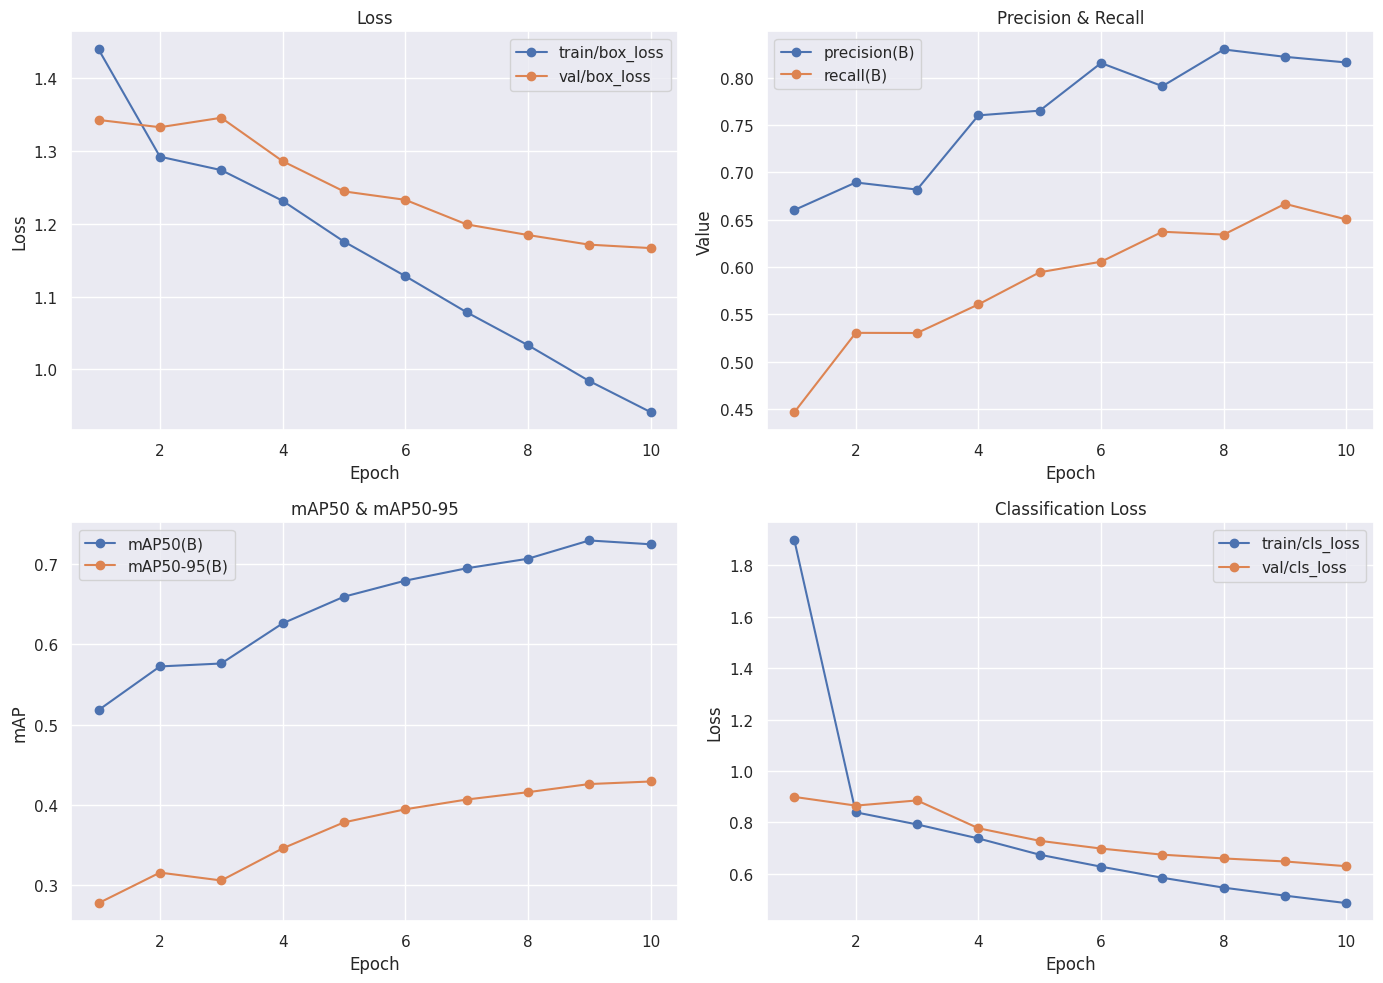

In [11]:
results = pd.read_csv("/kaggle/working/cv_task_part3/YOLOv8/results.csv")

# Построение графиков
plt.figure(figsize=(14, 10))

# График для потерь
plt.subplot(2, 2, 1)
plt.plot(results['epoch'], results['train/box_loss'], label='train/box_loss', marker='o')
plt.plot(results['epoch'], results['val/box_loss'], label='val/box_loss', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График для precision и recall
plt.subplot(2, 2, 2)
plt.plot(results['epoch'], results['metrics/precision(B)'], label='precision(B)', marker='o')
plt.plot(results['epoch'], results['metrics/recall(B)'], label='recall(B)', marker='o')
plt.title('Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# График для mAP50 и mAP50-95
plt.subplot(2, 2, 3)
plt.plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP50(B)', marker='o')
plt.plot(results['epoch'], results['metrics/mAP50-95(B)'], label='mAP50-95(B)', marker='o')
plt.title('mAP50 & mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()

# График для потерь по классу
plt.subplot(2, 2, 4)
plt.plot(results['epoch'], results['train/cls_loss'], label='train/cls_loss', marker='o')
plt.plot(results['epoch'], results['val/cls_loss'], label='val/cls_loss', marker='o')
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Посмотрим на результаты работы нашей модели

In [12]:
def show_comparison(images, true_labels, pred_labels, target_size, num_images=3, redefine_flag=True):
    plt.figure(figsize=(15, 5*num_images))
    
    for i in range(min(num_images, len(images))):
        image = images[i]
        true_label = true_labels[i]
        pred_label = pred_labels[i]
        
        img_np = image.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        
        img_true = img_np.copy()
        img_pred = img_np.copy()
        
        for ann in true_label:
            cls, x_center, y_center, w_box, h_box = ann
            if redefine_flag:
                cls = redefine_class(cls)
            x_min = int((x_center - w_box/2) * target_size)
            y_min = int((y_center - h_box/2) * target_size)
            x_max = int((x_center + w_box/2) * target_size)
            y_max = int((y_center + h_box/2) * target_size)
            cv2.rectangle(img_true, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(img_true, str(int(cls)), (x_min, y_min-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Отрисовка предсказанных bboxes (красные)
        for ann in pred_label:
            cls, x_center, y_center, w_box, h_box = ann
            if redefine_flag:
                cls = redefine_class(cls)
            x_min = int((x_center - w_box/2) * target_size)
            y_min = int((y_center - h_box/2) * target_size)
            x_max = int((x_center + w_box/2) * target_size)
            y_max = int((y_center + h_box/2) * target_size)
            cv2.rectangle(img_pred, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            cv2.putText(img_pred, str(int(cls)), (x_min, y_min-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        # Отображаем
        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(img_true)
        plt.title(f"True (Image {i+1})")
        plt.axis("off")
        
        plt.subplot(num_images, 2, 2*i+2)
        plt.imshow(img_pred)
        plt.title(f"Predicted (Image {i+1})")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

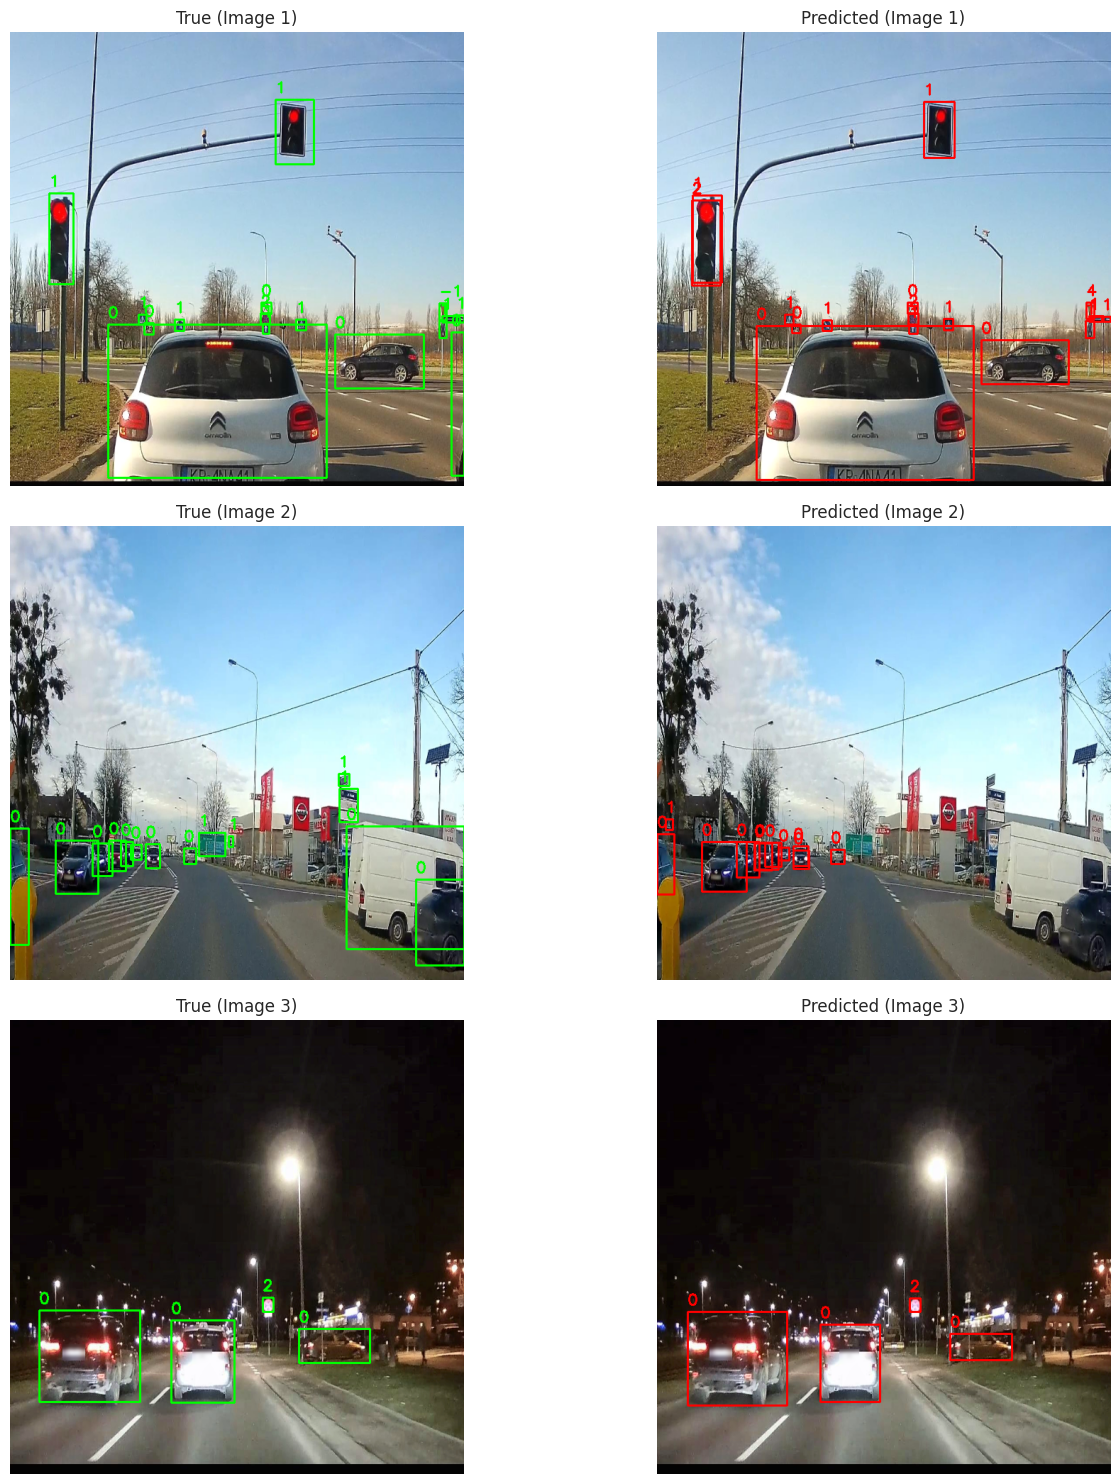

In [97]:
test_images, test_labels = next(iter(test_loader))

pred_labels = []
for img in test_images:
    img_np = img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    
    # Получаем предсказания
    results = model(img_np, verbose=False)
    
    img_preds = []
    for box in results[0].boxes:
        # Получаем координаты в абсолютных пикселях
        xywh = box.xywh[0].cpu().numpy()
        
        # Нормализуем координаты относительно target_size
        x_center_norm = xywh[0] / TARGET_SIZE
        y_center_norm = xywh[1] / TARGET_SIZE
        width_norm = xywh[2] / TARGET_SIZE
        height_norm = xywh[3] / TARGET_SIZE
        
        cls = box.cls.item()
        img_preds.append([cls, x_center_norm, y_center_norm, width_norm, height_norm])
    
    pred_labels.append(img_preds)

show_comparison(test_images, test_labels, pred_labels, TARGET_SIZE, num_images=3)

YOLO прекрасно справилась с задачей детекции.

Посмотрим на RetinaNet

In [14]:
def train_retinanet(model, train_loader, valid_loader, num_classes=6, num_epochs=10, lr=1e-4, target_size=TARGET_SIZE, developer_mode=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    train_losses, valid_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        counter = 0
        for images, targets in tqdm(train_loader, desc="Training"):
            images = [img.to(device) for img in images]
            counter += 1
            if developer_mode and counter > 1:
                break 
            
            valid_targets = []
            for i, t in enumerate(targets):
                _, h, w = images[i].shape
                
                boxes = torch.tensor(t[:, 1:], dtype=torch.float32) * target_size
                
                x_min = boxes[:, 0] - boxes[:, 2] / 2
                y_min = boxes[:, 1] - boxes[:, 3] / 2
                x_max = boxes[:, 0] + boxes[:, 2] / 2
                y_max = boxes[:, 1] + boxes[:, 3] / 2
                
                boxes = torch.stack([x_min, y_min, x_max, y_max], dim=1)
                
                mask = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
                valid_boxes = boxes[mask]
                valid_labels = torch.tensor(t[:, 0], dtype=torch.int64)[mask]
                
                valid_targets.append({"boxes": valid_boxes.to(device), "labels": valid_labels.to(device)})
            
            optimizer.zero_grad()
            loss_dict = model(images, valid_targets)
            
            loss = sum(loss_dict.values())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        valid_loss = 0.0
        counter = 0
        with torch.no_grad():
            for images, targets in tqdm(valid_loader, desc="Validating"):
                images = [img.to(device) for img in images]
                counter += 1
                if developer_mode and counter > 1:
                    break
                
                valid_targets = []
                for i, t in enumerate(targets):
                    boxes = torch.tensor(t[:, 1:], dtype=torch.float32) * target_size
                    
                    x_min = boxes[:, 0] - boxes[:, 2] / 2
                    y_min = boxes[:, 1] - boxes[:, 3] / 2
                    x_max = boxes[:, 0] + boxes[:, 2] / 2
                    y_max = boxes[:, 1] + boxes[:, 3] / 2
                    
                    boxes = torch.stack([x_min, y_min, x_max, y_max], dim=1)
                    
                    mask = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
                    valid_boxes = boxes[mask]
                    valid_labels = torch.tensor(t[:, 0], dtype=torch.int64)[mask]
                    
                    valid_targets.append({"boxes": valid_boxes.to(device), "labels": valid_labels.to(device)})
        
                model.train()  # Нужно для получения loss в режиме валидации
                loss_dict = model(images, valid_targets)
                model.eval()  # Вернуть обратно в eval
                
                valid_loss += sum(loss_dict.values())
        
        valid_losses.append(valid_loss.cpu() / len(valid_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

    return model, train_losses, valid_losses


def plot_losses(train_losses, valid_losses, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), valid_losses, label="Valid Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim((None, 10))
    plt.legend()
    plt.title(f"Training Progress")
    plt.show()

In [15]:
retina_model = retinanet_resnet50_fpn(
    weights=None,  
    num_classes=5
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s] 


In [19]:
num_epochs = 1
retina_model, train_losses, valid_losses = train_retinanet(retina_model, 
                                                  train_loader, 
                                                  valid_loader,
                                                  num_classes=5,
                                                  num_epochs = num_epochs,
                                                  developer_mode=False)

Training:   0%|          | 0/655 [00:00<?, ?it/s]

Validating:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 1/1, Train Loss: 0.6969, Valid Loss: 0.6310


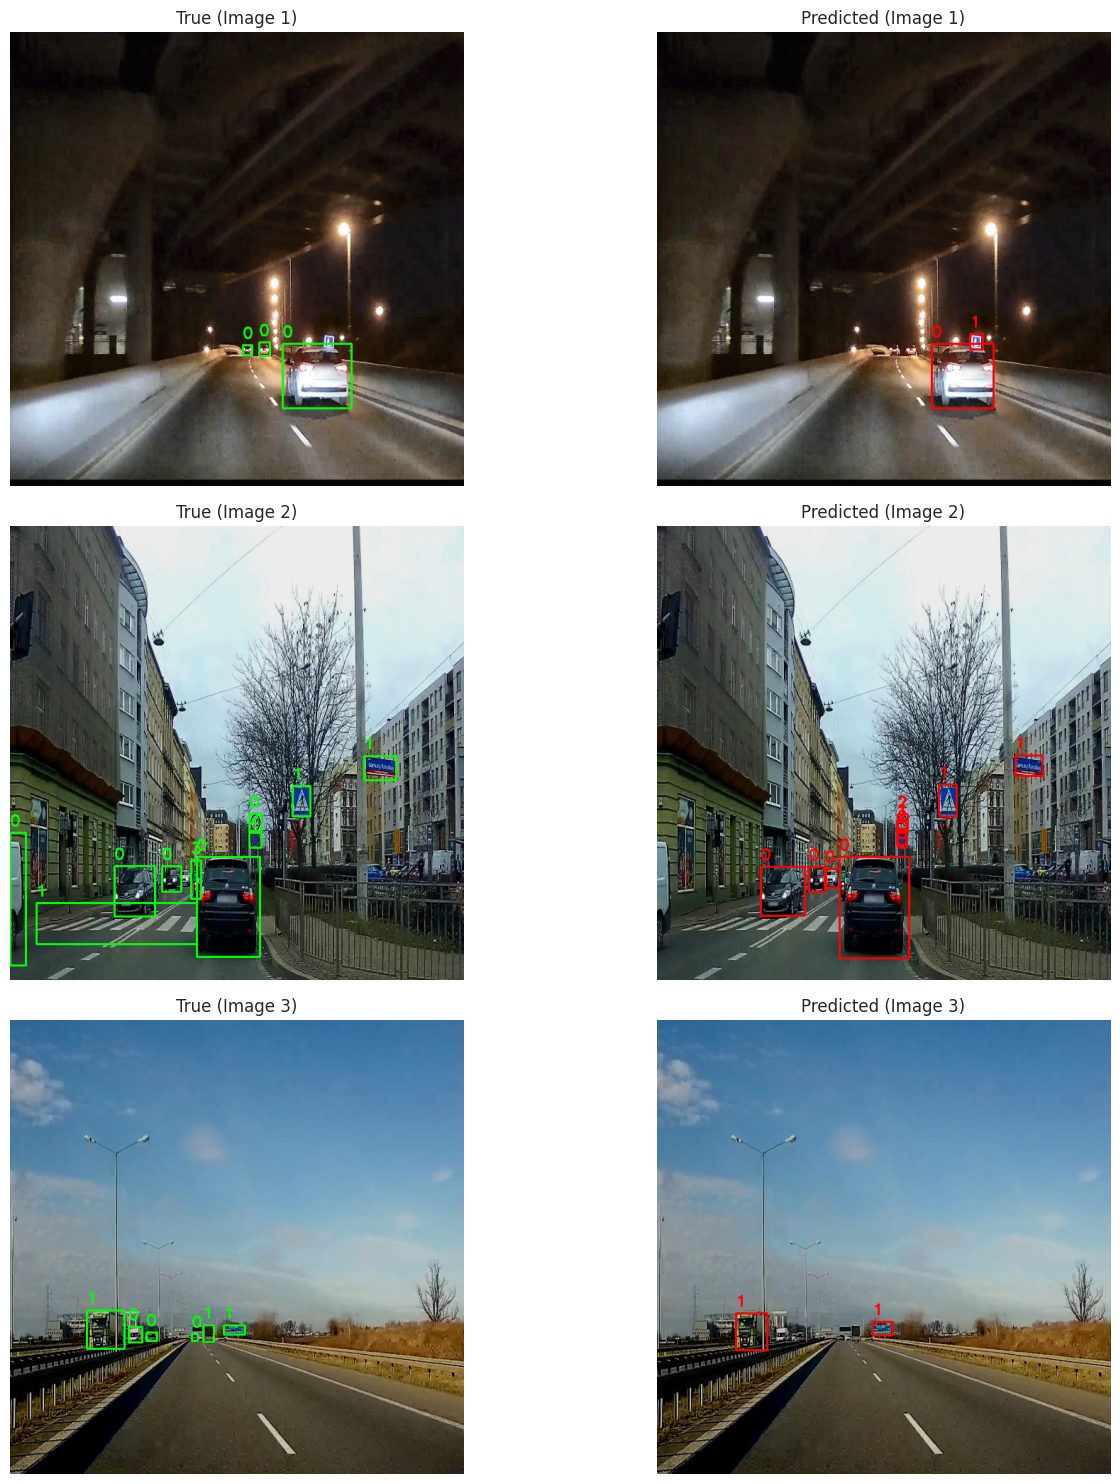

In [98]:
test_images, test_labels = next(iter(train_loader))

# Prepare the list to store predictions
pred_labels = []
retina_model.eval()

confidence_threshold = 0.4  # Убираем слишком слабые детекции

# Обрабатываем каждое изображение
for img in test_images:
    img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        results = retina_model(img)  # Get predictions from Retina model
    img_preds = []
    for box, score, label in zip(results[0]['boxes'], results[0]['scores'], results[0]['labels']):
        if score.item() < confidence_threshold:
            continue  # Пропускаем неуверенные предсказания
        
        # SSD возвращает (x_min, y_min, x_max, y_max), переводим в (x_center, y_center, w, h)
        x_min, y_min, x_max, y_max = box.cpu().numpy()
        width = x_max - x_min
        height = y_max - y_min
        x_center = x_min + width / 2
        y_center = y_min + height / 2

        # Нормализация координат
        x_center_norm = x_center / TARGET_SIZE
        y_center_norm = y_center / TARGET_SIZE
        width_norm = width / TARGET_SIZE
        height_norm = height / TARGET_SIZE
        
        cls = label.item()  # Class ID
        img_preds.append([cls, x_center_norm, y_center_norm, width_norm, height_norm])
    
    pred_labels.append(img_preds)

# Визуализация результатов
show_comparison(test_images.cpu(), test_labels, pred_labels, TARGET_SIZE, num_images=3, redefine_flag=False)

RetinaNet тоже справилась неплохо.

Все же для следующей задачи возьме YOLO из-за удобства работы с ней.


В этой части предлагается сделать видео с демонстрацией работы модели из предыдущей части в реальных условиях.

#### Этапы работы

1. **Сбор данных**
    - Вариант 1 (рекомендуемый): запишите видео дороги в Долгопрудном, например, ваш путь до Мираторга, Дирижабля или 13/14 общежитий.
    - Вариант 2: если по каким-то причинам самому снять видео не получается, разрешается взять любое видео с камеры автомобиля из youtube.

2. **Применение моделей.** К каждому кадру примените обученную модель детекции из части 3.

3. **Визуализация.** Отобразите на каждом кадре предсказанные боксы и их классы. Затем склейте их обратно в видео.

4. **Стабилизация боксов.** Скорее всего качество полученного видео вас не устроит, так как боксы будут дрожать из-за подрешностей в предсказаниях между соседними кадрами. Для этого предлагается реализовать сглаживание боксов детекций. Например, можно попробовать экспоненциальное скользящее среднее для координат боксов.

*Совет.* В этой части крайне приветствуется использование LLM для:
- Написания и оптимизации кода;
- Идей по красивой визуализации боксов и подписей;
- Идей для решения технических проблем, особенно со стабилизацией в 4 пункте.

Полученное видео загрузите на диск и прикрепите ссылку на него.

In [121]:
class BoxStabilizer:
    def __init__(self, buffer_size=5):
        self.buffer_size = buffer_size
        self.history = {}  # {track_id: [boxes]}

    def stabilize_box(self, track_id, box):
        box = np.array(box)
        if track_id not in self.history:
            self.history[track_id] = []
        self.history[track_id].append(box)
        if len(self.history[track_id]) > self.buffer_size:
            self.history[track_id].pop(0)
        avg_box = np.mean(self.history[track_id], axis=0)
        return avg_box.astype(int)

def load_model(model_path):
    """Загружает обученную модель YOLO."""
    model = YOLO(model_path)
    return model

def process_frame(frame, model, class_names, stabilizer=None):
    """Обрабатывает кадр, делая предсказания YOLO и накладывая стабилизированные боксы."""
    # Используем трекинг для получения ID объектов
    results = model.track(frame, persist=True, verbose=False)
    
    for result in results:
        for box in result.boxes:
            # Пропускаем боксы без ID трека
            if box.id is None:
                continue
            track_id = int(box.id.item())
            xyxy = box.xyxy[0].cpu().numpy()
            
            # Применяем стабилизацию
            if stabilizer is not None:
                x1, y1, x2, y2 = stabilizer.stabilize_box(track_id, xyxy)
            else:
                x1, y1, x2, y2 = map(int, xyxy)

            class_id = int(box.cls)
            class_id = redefine_class(class_id)
            conf = box.conf.item()
            
            if class_id != -1:
                label = f"{class_names[class_id]}: {conf:.2f}"
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1-10), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    
    return frame

def process_video_frames(frames_folder, model, class_names, output_video):
    """Обрабатывает кадры со стабилизацией и собирает видео."""
    frame_files = sorted(os.listdir(frames_folder))
    frame_path = os.path.join(frames_folder, frame_files[0])
    frame_sample = cv2.imread(frame_path)
    h, w = frame_sample.shape[:2]
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, 30, (w, h))
    
    stabilizer = BoxStabilizer(buffer_size=10)  # Размер буфера для сглаживания
    
    for frame_file in tqdm(frame_files, desc="Обработка кадров"):
        frame = cv2.imread(os.path.join(frames_folder, frame_file))
        processed_frame = process_frame(frame, model, class_names, stabilizer)
        out.write(processed_frame)
    
    out.release()

In [122]:
# Параметры
model_path = "/kaggle/working/cv_task_part3/YOLOv8/weights/best.pt"  
frames_folder = "/kaggle/input/video-frames/frames" 
output_video = "output.mp4"
class_names = ["Car", "Road_sign", "Traffic light", "Pedestrian", "Motorcyclist"]  

model_tmp = load_model(model_path)
process_video_frames(frames_folder, model_tmp, class_names, output_video)

Обработка кадров:   0%|          | 0/5918 [00:00<?, ?it/s]

Итоговый результат можно посмотреть по [ссылке](https://disk.yandex.ru/d/xA07TkQUe34tzQ).

Благодаря стабилизации получилось достаточно неплохо.